# Mapping crimes in Boyle Heights

In [1]:
# https://github.com/dnanhkhoa/nb_black
%load_ext lab_black

### Import data tools

In [2]:
import pandas as pd
import geopandas as gpd
import pyarrow
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import fiona
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import altair as alt
import altair_latimes as lat

alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Run if most-recent data is needed

In [3]:
# %run '00-lapd-crimes-processing.ipynb'

### Read crimes CSV downloaded from LA City data portal

In [4]:
crimes = pd.read_csv(
    "/Users/mhustiles/data/data/LA/crimes.csv",
    dtype={
        "area_name": str,
        "rpt_dist_no": str,
        "weapon_used_cd": str,
        "crm_cd": str,
        "premises_code": str,
        "division": str,
    },
)

In [5]:
# crimes.drop(
#     [
#         "crime_code",
#         "victim_descent",
#         "division",
#         "part_type",
#         "crime_code",
#         "weapon_code",
#         "status_code",
#         "crm_cd_1",
#         "crm_cd_2",
#         "crm_cd_3",
#         "crm_cd_4",
#         "cross_street",
#     ],
#     axis=1,
#     inplace=True,
# )

### How many Part 1 crimes? 

In [6]:
len(crimes)

848719

### Boyle Heights spans across parts of three LAPD districts. Let's isolate the data frame to them for now

In [7]:
boyle_area_divisions = ["Central", "Hollenbeck", "Newton"]

In [8]:
boyle_heights_area_crimes = crimes[crimes["division_name"].isin(boyle_area_divisions)]

### How many Part 1 crimes are looking at now? 

In [9]:
len(boyle_heights_area_crimes)

109067

---

## Import mapping data

In [10]:
# Transform our crimes data into a geoDataFrame
boyle_heights_area_crimes_geo = gpd.GeoDataFrame(
    boyle_heights_area_crimes,
    geometry=gpd.points_from_xy(
        boyle_heights_area_crimes.longitude, boyle_heights_area_crimes.latitude
    ),
)

### Set the geographic file's coordinate reference system

In [11]:
boyle_heights_area_crimes_geo = boyle_heights_area_crimes_geo.set_crs("EPSG:4326")
boyle_heights_area_crimes_geo = boyle_heights_area_crimes_geo.set_crs(epsg=4326)

### Read LAPD reporting districts

In [12]:
districts = gpd.read_file("input/LAPD_Reporting_Districts/LAPD_Reporting_Districts.shp")

### Read LAPD divisions

In [13]:
divisions = gpd.read_file("input/LAPD_Divisions/LAPD_Divisions.shp")

### Read LA Times neighborhoods

In [14]:
hoods = gpd.read_file("input/custom-la-hoods-skid-row.geojson")

---

## Isolate just Boyle Heights crimes

### First, get the neighborhood boundary

In [15]:
boyle_heights = hoods[hoods["name"] == "Boyle Heights"]

### Next, get only those crimes within the boundaries by performing a spatial merge

In [16]:
bh_crimes = gpd.sjoin(
    boyle_heights_area_crimes_geo, boyle_heights, how="inner", op="within"
)

### Did it work? 

<AxesSubplot:>

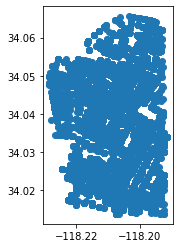

In [17]:
bh_crimes.plot()

### How many crimes now? 

In [18]:
len(bh_crimes)

17696

---

## Basic aggregates on variables for all crimes

### Which crimes are most common? 

In [19]:
violations = (
    bh_crimes.groupby(["crime_code_description"])
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [20]:
violations.head(10)

,crime_code_description,total
40,Vehicle - stolen,4232
34,Theft plain - petty ($950 & under),2287
2,"Assault with deadly weapon, aggravated assault",1963
8,Burglary from vehicle,1759
31,Theft from motor vehicle - petty ($950 & under),1463
21,Robbery,1440
7,Burglary,1420
37,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",783
30,Theft from motor vehicle - grand ($400 and over),344
6,Brandish weapon,238


### Places where crimes occur?

In [21]:
places = (
    bh_crimes.groupby(["premises_description"])
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [22]:
places.head(5)

,premises_description,total
108,Street,7620
86,Parking lot,1683
104,Single family dwelling,1552
103,Sidewalk,944
80,Other business,893


### Aggregates for police geography

In [23]:
divisions = (
    bh_crimes.groupby(["division_name", "crime_code_description", "year"])
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [24]:
divisions.head()

,division_name,crime_code_description,year,total
280,Hollenbeck,Vehicle - stolen,2020,711
278,Hollenbeck,Vehicle - stolen,2015,599
273,Hollenbeck,Vehicle - stolen,2010,597
275,Hollenbeck,Vehicle - stolen,2012,549
277,Hollenbeck,Vehicle - stolen,2014,517


In [25]:
districts = (
    bh_crimes.groupby(
        ["reporting_district", "division_name", "crime_code_description", "year"]
    )
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [26]:
districts.head()

,reporting_district,division_name,crime_code_description,year,total
3522,497,Hollenbeck,Vehicle - stolen,2020,70
3515,497,Hollenbeck,Vehicle - stolen,2010,69
3640,499,Hollenbeck,Vehicle - stolen,2020,61
3517,497,Hollenbeck,Vehicle - stolen,2012,53
3520,497,Hollenbeck,Vehicle - stolen,2015,53


---

## Boyle Heights homicides

In [27]:
bh_homicides = gpd.GeoDataFrame(
    bh_crimes[bh_crimes["crime_code_description"] == "Criminal homicide"]
)

In [28]:
bh_homicides.head()

,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitude,division.1,year,quarter,day,month,weekday,monthname,descent_description,hour,minute,part_category,geometry,index_right,name
17914,200405562,2020-02-10,2020-02-10,200,4.0,Hollenbeck,449,1,110.0,Criminal homicide,0913 1100 1402 0430 1820 0302 1309 0906,29.0,male,H,501,Single family dwelling,109.0,Semi-automatic pistol,AA,adult_arrest,110.0,NaN,NaN,NaN,2600 MARENGO ST,NaN,34.0545,-118.1992,NaN,2020,1,10,2,0,February,hispanic,2,0,other,POINT (-118.19920 34.05450),9,Boyle Heights
30992,200407038,2020-03-17,2020-03-17,905,4.0,Hollenbeck,478,1,110.0,Criminal homicide,0302 0334 0430 0202 0906 1100 2004 1407 1822 0341,26.0,male,H,102,Sidewalk,109.0,Semi-automatic pistol,AA,adult_arrest,110.0,998.0,NaN,NaN,900 GRANDE VISTA AV,NaN,34.0280,-118.2048,NaN,2020,1,17,3,1,March,hispanic,9,5,other,POINT (-118.20480 34.02800),9,Boyle Heights
36689,200401071,2020-09-26,2020-09-26,900,4.0,Hollenbeck,453,1,110.0,Criminal homicide,1822 0400 0416 0429 1202,62.0,male,H,101,Street,400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,110.0,NaN,NaN,NaN,1800 PENNSYLVANIA AV,NaN,34.0475,-118.2169,NaN,2020,3,26,9,5,September,hispanic,9,0,other,POINT (-118.21690 34.04750),9,Boyle Heights
50062,200407880,2020-04-16,2020-04-15,2259,4.0,Hollenbeck,466,1,110.0,Criminal homicide,1402 1407 0946 1270 1809 1822 1100 0906 0430,45.0,male,H,108,Parking lot,102.0,Hand gun,AA,adult_arrest,110.0,998.0,NaN,NaN,2800 E CESAR E CHAVEZ AV,NaN,34.0445,-118.2025,NaN,2020,2,15,4,2,April,hispanic,22,59,other,POINT (-118.20250 34.04450),9,Boyle Heights
50373,200408872,2020-05-15,2020-05-15,710,4.0,Hollenbeck,453,1,110.0,Criminal homicide,0906 1822 1100 0430 0334 1407 0302,40.0,male,H,109,Park/playground,102.0,Hand gun,IC,invest_cont,110.0,998.0,NaN,NaN,700 ECHANDIA ST,NaN,34.0542,-118.2172,NaN,2020,2,15,5,4,May,hispanic,7,10,other,POINT (-118.21720 34.05420),9,Boyle Heights


### Plot the homicides by year

In [29]:
bh_homicides_yr = bh_homicides.groupby(["year"]).agg("size").reset_index(name="count")

In [30]:
bh_homicides_yr.year = bh_homicides_yr.year.astype(str)

In [31]:
lines = (
    alt.Chart(
        bh_homicides_yr,
        title="Boyle Heights homicides, by year",
    )
    .mark_bar()
    .encode(
        x=alt.X(
            "year:N",
            axis=alt.Axis(grid=False, title=""),
        ),
        y=alt.Y(
            "count:Q",
            scale=alt.Scale(domain=(0, 25)),
            axis=alt.Axis(
                gridColor="#dddddd",
                offset=6,
                tickSize=0,
                domainOpacity=0,
                tickCount=6,
                title="Homicides",
            ),
        ),
    )
)

# go
(lines).properties(height=400, width=800).configure_view(strokeOpacity=0)

alt.Chart(...)

---

## Descriptives

### Where are these homicides occuring? 

Rougly half occurr on streets and sidewalks

In [32]:
round(bh_homicides.premises_description.value_counts("normalize") * 100)

Street                                                29.0
Sidewalk                                              21.0
Parking lot                                           12.0
Single family dwelling                                 8.0
Multi-unit dwelling (apartment, duplex, etc)           5.0
Porch, residential                                     3.0
Alley                                                  3.0
Driveway                                               3.0
Yard (residential/business)                            2.0
Freeway                                                2.0
Park/playground                                        2.0
Other/outside                                          2.0
Vacant lot                                             1.0
Government facility (federal,state, county & city)     1.0
Other premise                                          1.0
Project/tenement/public housing                        1.0
Mta - gold line - soto                                 1

### What times do these homicides occur? 

About 30% happen between 10pm and 2 am, it seems

In [33]:
bh_homicides_slim = bh_homicides[
    [
        "date_occurred",
        "hour",
        "victim_age",
        "victim_sex",
        "premises_description",
        "descent_description",
        "status_code_description",
    ]
]

In [34]:
alt.Chart(bh_homicides_slim).mark_bar().encode(
    alt.X("hour:Q", bin=alt.Bin(maxbins=12)),
    y="count()",
)

alt.Chart(...)

### What's the share of 10pm-2am homicides?

In [35]:
all_homicides = len(bh_homicides_slim)

In [36]:
midnight_homicides = len(
    bh_homicides_slim[
        (bh_homicides_slim["hour"] > 22) | (bh_homicides_slim["hour"] < 3)
    ]
)

In [37]:
round((midnight_homicides / all_homicides) * 100, 2)

29.07

### Have the cases been resolved? 

Half remain unsolved

In [38]:
round(bh_homicides_slim.status_code_description.value_counts("normalize") * 100)

invest_cont     52.0
adult_arrest    41.0
adult_other      5.0
juv_arrest       2.0
Name: status_code_description, dtype: float64

### What is the average age of the victims? 

In [39]:
round(bh_homicides_slim.victim_age.mean())

30

### Most of the victims are men ...

In [40]:
round(bh_homicides_slim.victim_sex.value_counts("normalize") * 100)

male       88.0
female     10.0
unknown     1.0
Name: victim_sex, dtype: float64

### ... and Latino

In [41]:
round(bh_homicides_slim.descent_description.value_counts("normalize") * 100)

hispanic    95.0
white        3.0
other        1.0
Name: descent_description, dtype: float64

---

## Geography

In [42]:
bh_homicides.sort_values("date_occurred", ascending=False).head()

,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitude,division.1,year,quarter,day,month,weekday,monthname,descent_description,hour,minute,part_category,geometry,index_right,name
114580,210404306,2021-01-09,2021-01-09,2048,4.0,Hollenbeck,456,1,110.0,Criminal homicide,1100 1822 0430,59.0,male,H,101,Street,102.0,Hand gun,IC,invest_cont,110.0,NaN,NaN,NaN,700 N FICKETT ST,NaN,34.0495,-118.2036,NaN,2021,1,9,1,5,January,hispanic,20,48,other,POINT (-118.20360 34.04950),9,Boyle Heights
113784,210404049,2021-01-02,2021-01-02,1530,4.0,Hollenbeck,453,1,110.0,Criminal homicide,0906 1822 0430 1402 1100,15.0,male,H,107,Vacant lot,102.0,Hand gun,IC,invest_cont,110.0,998.0,NaN,NaN,600 ECHANDIA ST,NaN,34.0527,-118.2183,NaN,2021,1,2,1,5,January,hispanic,15,30,other,POINT (-118.21830 34.05270),9,Boyle Heights
111593,200416452,2020-12-31,2020-12-31,855,4.0,Hollenbeck,497,1,110.0,Criminal homicide,1100 1822 1218 0430,45.0,male,H,116,Other/outside,106.0,Unknown firearm,IC,invest_cont,110.0,NaN,NaN,NaN,2800 E LUGO ST,NaN,34.0166,-118.2200,NaN,2020,4,31,12,3,December,hispanic,8,55,other,POINT (-118.22000 34.01660),9,Boyle Heights
112342,200416098,2020-12-19,2020-12-19,1719,4.0,Hollenbeck,464,1,110.0,Criminal homicide,1822 0430 1100 0906,23.0,female,H,101,Street,102.0,Hand gun,AA,adult_arrest,110.0,NaN,NaN,NaN,200 S SOTO ST,NaN,34.0445,-118.2116,NaN,2020,4,19,12,5,December,hispanic,17,19,other,POINT (-118.21160 34.04450),9,Boyle Heights
111747,200416099,2020-12-19,2020-12-19,1719,4.0,Hollenbeck,464,1,110.0,Criminal homicide,1822 0430 0906,22.0,male,H,101,Street,102.0,Hand gun,AA,adult_arrest,110.0,NaN,NaN,NaN,200 S SOTO ST,NaN,34.0445,-118.2116,NaN,2020,4,19,12,5,December,hispanic,17,19,other,POINT (-118.21160 34.04450),9,Boyle Heights


### 2010-2021 homicides

In [43]:
# Boyle Heights neighborhood background
background = (
    alt.Chart(boyle_heights)
    .mark_geoshape(fill="lightgray", stroke="white")
    .properties(width=500, height=800)
)

# homicide positions on background
points = (
    alt.Chart(bh_homicides)
    .mark_circle(size=150)
    .encode(
        longitude="longitude:Q",
        latitude="latitude:Q",
        color=alt.Color("year:N", scale=alt.Scale(scheme="category10")),
        tooltip=[
            "record_id:N",
            "year:N",
            "date_occurred:N",
            "premises_description:N",
            "weapon_description:N",
        ],
    )
)

(background + points).properties(height=600, width=300).configure_legend(
    symbolType="circle", symbolSize=70
)

alt.LayerChart(...)

### 2020 homicides

In [44]:
# Boyle Heights neighborhood background
background = (
    alt.Chart(boyle_heights)
    .mark_geoshape(fill="lightgray", stroke="white")
    .properties(width=500, height=800)
)

# homicide positions on background
points = (
    alt.Chart(bh_homicides.query("year == 2020"))
    .mark_circle(size=150)
    .encode(
        longitude="longitude:Q",
        latitude="latitude:Q",
        color=alt.Color("year:N", scale=alt.Scale(scheme="category10")),
        tooltip=[
            "record_id:N",
            "year:N",
            "date_occurred:N",
            "premises_description:N",
            "weapon_description:N",
        ],
    )
)

(background + points).properties(height=600, width=300).configure_legend(
    symbolType="circle", symbolSize=70
)

alt.LayerChart(...)

---

## Export

In [45]:
bh_homicides.to_file("output/bh_homicides.geojson", driver="GeoJSON")

In [46]:
bh_homicides[bh_homicides["year"] == 2020].to_file(
    "output/bh_homicides_2020.geojson", driver="GeoJSON"
)

In [47]:
fiona.supported_drivers["KML"] = "rw"
bh_homicides.to_file("output/bh_homicides.kml", driver="KML")

In [48]:
bh_homicides.to_csv("output/bh_homicides.csv", index=False)

In [49]:
bh_homicides[bh_homicides["year"] == 2020].to_csv(
    "output/bh_homicides_2020.csv", index=False
)

In [50]:
boyle_heights_area_crimes.to_csv("input/boyle_heights_area_crimes.csv", index=False)